In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile
# import os

# zip_path = '/content/drive/MyDrive/DL_A2/nature_12K.zip'
# extract_path = '/content/drive/MyDrive/DL_A2/dataset'  # or just '/content/' to extract here

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [1]:
import cv2

img = cv2.imread('/kaggle/input/dldata/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg')
height, width, channels = img.shape
print(f'Width: {width}, Height: {height}, Channels: {channels}')

Width: 800, Height: 600, Channels: 3


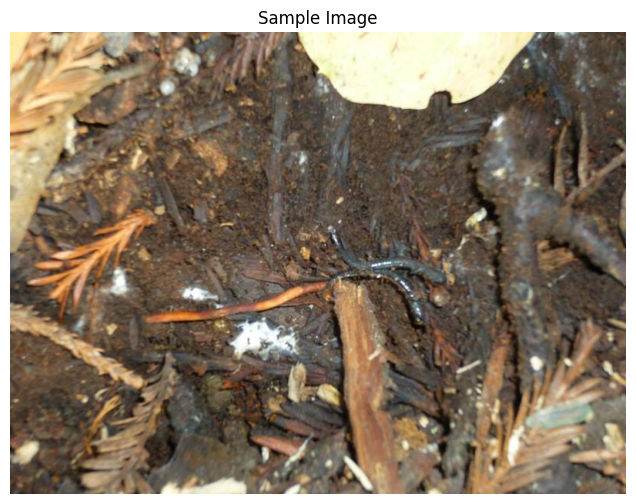

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load image using OpenCV
image_path = '/kaggle/input/dldata/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg'
image = cv2.imread(image_path)

# Convert BGR (OpenCV default) to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Sample Image")
plt.show()

# Part A

### Question 1



Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer.

After 5 such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10classes). The input layer should be compatible with the images in the iNaturalist dataset dataset.

The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.

In [3]:
%pip install -q wandb

Note: you may need to restart the kernel to use updated packages.


In [3]:
import wandb

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("WANDB_API_KEY") 

wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m013 (da24m013-iit-madras-alumni-association) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
dataset_path = "/kaggle/input/dldata/inaturalist_12K/train"

In [28]:
import os
import random
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

# For reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

# Define the CNN model
class CustomCNN(nn.Module):
    def __init__(self, conv_params, dense_neurons, activation_fn, dropout=0.0, batch_norm=False):
        super(CustomCNN, self).__init__()
        layers = []
        in_channels = 3
        for out_channels, kernel_size in conv_params:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        self.conv = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(out_channels * 7 * 7, dense_neurons),  # Assuming input size 224x224 → downsampled 32x7x7
            activation_fn(),
            nn.Dropout(dropout),
            nn.Linear(dense_neurons, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

# Activation mapper
activation_map = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "silu": nn.SiLU,
    "mish": nn.Mish
}

# Stratified split
def stratified_split(dataset, test_size=0.2):
    targets = [sample[1] for sample in dataset.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_idx, val_idx in sss.split(dataset.samples, targets):
        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)
        return train_dataset, val_dataset

In [ ]:
def train_model(config=None, sweep=False):
    # WandB init with thread-safe settings for Colab
    if sweep:
        run = wandb.init(config=config, settings=wandb.Settings(start_method="thread"))
        config = wandb.config
    else:
        if config is not None:
            config.update(config)
        run = wandb.init(
            project="DA6401-A2",
            config=config,
            name=None,
            reinit=True,
            settings=wandb.Settings(start_method="thread")
        )
        config = wandb.config  # Ensure consistency

    # Run name for better visualization
    run_name = (
        f"nl_{config['num_filters']}_bs_{config['batch_size']}_"
        f"hs_{config['dense_neurons']}_ac_{config['activation']}_"
        f"dr_{config['dropout']}_bn_{int(config['batch_norm'])}"
    )
    wandb.run.name = run_name
    wandb.run.save()

    set_seed()

    # Data transforms
    base_transforms = [transforms.Resize((224, 224)), transforms.ToTensor()]
    if config["data_aug"]:
        base_transforms.insert(0, transforms.RandomHorizontalFlip())
        base_transforms.insert(0, transforms.RandomRotation(15))
    transform = transforms.Compose(base_transforms)

    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    train_dataset, val_dataset = stratified_split(dataset)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)

    # Conv architecture config
    if config["filter_scheme"] == "same":
        conv_params = [(config["num_filters"], 3)] * 5
    elif config["filter_scheme"] == "double":
        conv_params = [(config["num_filters"] * (2**i), 3) for i in range(5)]
    else:  # halving
        conv_params = [(max(8, config["num_filters"] // (2**i)), 3) for i in range(5)]

    model = CustomCNN(
        conv_params,
        config["dense_neurons"],
        activation_map[config["activation"]],
        config["dropout"],
        config["batch_norm"]
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    best_val_acc = 0
    best_epoch = -1

    for epoch in range(config["epochs"]):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate(model, val_loader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            if not sweep:
                torch.save(model.state_dict(), "best_model.pth")
                wandb.save("best_model.pth")

        wandb.log({
            "epoch": epoch + 1,
            "loss": running_loss / len(train_loader),
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        print(f"Epoch {epoch+1}/{config['epochs']}: "
              f"Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Final results
    if not sweep:
        print("\nTraining Completed!")
        print(f"Best Val Acc: {best_val_acc:.2f}% at epoch {best_epoch}")
        print("Best Parameters:")
        for k, v in config.items():
            print(f"  {k}: {v}")

    wandb.run.summary["best_val_acc"] = best_val_acc
    wandb.run.summary["best_epoch"] = best_epoch
    wandb.finish()

In [ ]:

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

In [ ]:
# sweep_config = {
#     "method": "bayes",
#     "metric": {"name": "val_acc", "goal": "maximize"},
#     "parameters": {
#         "epochs": {"value": 5},
#         "lr": {"values": [1e-3, 5e-4, 1e-4]},
#         "batch_size": {"values": [32, 64]},
#         "num_filters": {"values": [32, 64]},
#         "filter_scheme": {"values": ["same", "double", "half"]},
#         "activation": {"values": ["relu", "gelu", "silu", "mish"]},
#         "dropout": {"values": [0.2, 0.3]},
#         "dense_neurons": {"values": [128, 256]},
#         "data_aug": {"values": [True, False]},
#         "batch_norm": {"values": [True, False]},
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project="DA6401-A2")
# wandb.agent(sweep_id, function=train_model, count=100)  # Run 10 trials

In [ ]:
best_config = {
    "epochs": 25,
    "lr": 0.0001,
    "batch_size": 32,
    "num_filters": 64,
    "filter_scheme": "same",
    "activation": "silu",
    "dropout": 0.3,
    "dense_neurons": 256,
    "data_aug": True,
    "batch_norm": True
}


train_model(best_config, sweep=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# === 1. Define test transforms (no augmentation) ===
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === 2. Load the test dataset ===
test_path = "/kaggle/input/dldata/inaturalist_12K/val"
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
class_names = test_dataset.classes

# === 3. Load your best model ===
# Rebuild the model with best config
best_config = {
    "epochs": 25,
    "lr": 0.0001,
    "batch_size": 32,
    "num_filters": 64,
    "filter_scheme": "same",
    "activation": "silu",
    "dropout": 0.3,
    "dense_neurons": 256,
    "data_aug": True,
    "batch_norm": True
}

if best_config["filter_scheme"] == "same":
    conv_params = [(best_config["num_filters"], 3)] * 5
elif best_config["filter_scheme"] == "double":
    conv_params = [(best_config["num_filters"] * (2**i), 3) for i in range(5)]
else:
    conv_params = [(max(8, best_config["num_filters"] // (2**i)), 3) for i in range(5)]

model = CustomCNN(
    conv_params,
    best_config["dense_neurons"],
    activation_map[best_config["activation"]],
    best_config["dropout"],
    best_config["batch_norm"]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# === 4. Evaluate on test set ===
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# === 5. Log to W&B ===
wandb.init(project="DA6401-A2", name="best_model_test_eval")
wandb.log({"test_accuracy": test_acc})

# === 6. Create and log 10×3 prediction grid ===
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
indices = np.random.choice(len(test_dataset), 30, replace=False)

for ax, idx in zip(axs.flatten(), indices):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).item()

    ax.imshow(image.permute(1, 2, 0).cpu())
    ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
    ax.axis('off')

plt.tight_layout()
wandb.log({"Test Predictions Grid": wandb.Image(fig)})
wandb.finish()